AI_Translator
=

### 오늘을 번역기를 만들어볼 것 입니다.
### 그나저나, 너무 놀랍네요. 번역기를 만들 수 있다니.. 사실 지금까지 배운내용이면, 분명 만들 수 있어야하긴 한데;; 혼자서는 너무 자신이 없네요. 한번 교육과정의 도움을 받아 만들어보도록 하겠습니다.

# 목차
## 1. 목적 및 의의
## 2. 이론
## 3. 실습
## 4. 회고

# 1. 목적 및 의의
## 1) Seq2seq 구조를 이해하고 이를 토대로 번역기를 만들어본다. 
## 2) Attention 을 구현하여, 성능을 높여보고, 이를 이해한다.

# 2. 이론

# 3. 실습

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
# %config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
# mpl.font_manager.findfont(font)
print("글꼴이 없다면 terminal에")
print("sudo apt -qq -y install fonts-nanum")
print("를 하세요!")

글꼴이 없다면 terminal에
sudo apt -qq -y install fonts-nanum
를 하세요!


In [32]:
!nvidia-smi

Tue Jan  4 16:07:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   27C    P0    80W / 149W |   8472MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.4.1


In [34]:
now_path = "aiffel/Data/kor_en/"
path_to_enfile = "data/kor_en/korean-english-park.train.en"
path_to_kofile = "data/kor_en/korean-english-park.train.ko"
path_to_enfile = now_path + path_to_enfile
path_to_kofile = now_path + path_to_kofile

In [35]:
with open(path_to_enfile, "r") as f:
    en_raw = f.read().splitlines()

with open(path_to_kofile, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size:", len(en_raw))
print("Example:")

for sen in list(zip(en_raw, ko_raw))[0:100][::20]: print(">>", *sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?" 개인 컴퓨팅의 상당 부분은 "이것을 넘어설 수 있느냐?" 관한 것이다.
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations. 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said. "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project. 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes. 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 

In [36]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,\s]+", "", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


In [37]:
# enc_corpus = []
# dec_corpus = []

# num_examples = 30000

print("English:", en_raw[100]) 
print("Korean:", ko_raw[100])  

English: Gates, who opened the 23rd annual Comdex trade show, said there was a negative perception of high tech following the collapse of the tech bubble about two years ago.
Korean: 제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다.


In [38]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=20000)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [39]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(en_raw)
dec_tensor, dec_tokenizer = tokenize(ko_raw)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Korean Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 101881
Korean Vocab Size: 241331


### 여기서 한국어를 다루기 어려움이 조금 드러나는 것 같아요. 같은 단어도 조사에 따라 다른 단어로 분류되고, 어간 어미가 너무 다양하니까요.
### 여기서 형태소 분류기를 사용하고 가야할 것 같습니다.

In [40]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [41]:
from konlpy.tag import Mecab

mecab = Mecab()

enc_corpus = []
dec_corpus = []

num_examples = 20000


for i in range(num_examples):
    enc_corpus.append(mecab.morphs(preprocess_sentence(en_raw[i])))
    dec_corpus.append(["<start>"]+mecab.morphs(preprocess_sentence(ko_raw[i]))+["<end>"])

print(enc_corpus[100])
print(dec_corpus[100])


['gates', ',', 'who', 'opened', 'the', '23', 'rd', 'annual', 'comdex', 'trade', 'show', ',', 'said', 'there', 'was', 'a', 'negative', 'perception', 'of', 'high', 'tech', 'following', 'the', 'collapse', 'of', 'the', 'tech', 'bubble', 'about', 'two', 'years', 'ago', '.']
['<start>', '제', '23', '차', '연례', '컴덱스', '박람회', '의', '개회사', '를', '한', '케이츠', '는', '2', '년', '여전', '기술', '산업', '의', '거품', '이', '붕괴', '된', '이후', '에', '첨단', '기술', '에', '대해', '부정', '적', '인', '인식', '이', '있', '다고', '말', '했', '다', '.', '<end>']


In [42]:
def num_of_word(corpus):
    length_sen = [0]*len(corpus)
    for i, j in enumerate(corpus):
        length_sen[i] = len(j)
    return length_sen

from collections import Counter

def make_graph(length_sen):
    num_num = Counter(length_sen)
    plt.figure(figsize=(16,10))
    plt.bar(range(len(num_num)),[num_num[i] for i in range(len(num_num))],)
    plt.show()



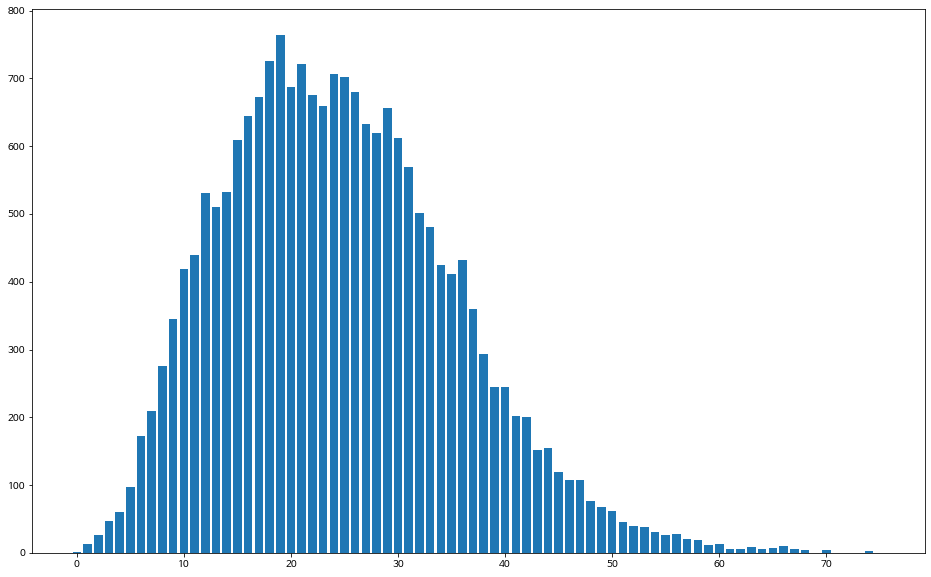

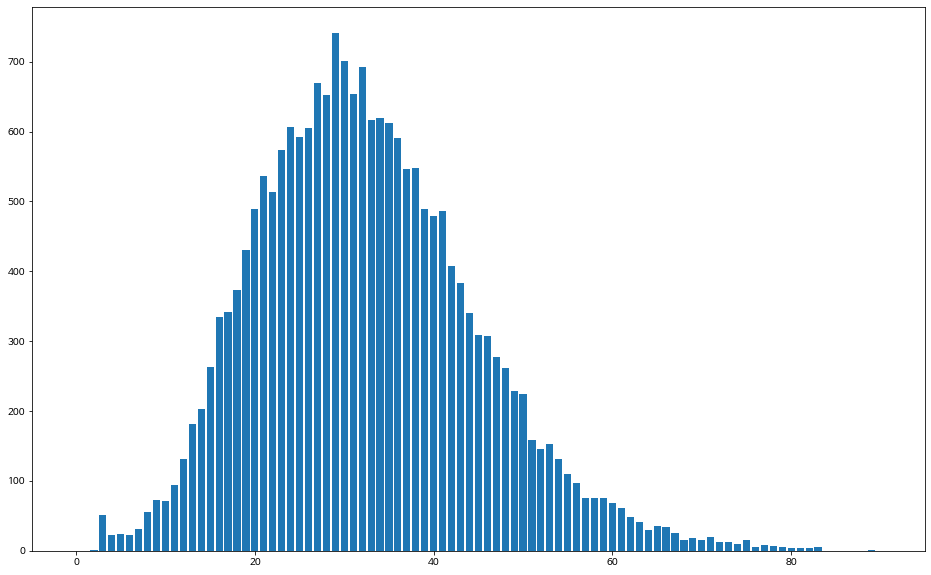

In [43]:
make_graph(num_of_word(enc_corpus))
make_graph(num_of_word(dec_corpus))

### 문장 텐서의 길이가 답이 없이 길어지기 전에, 길이 제한을 좀 해보겠습니다.
### 많이 줄이지는 않을거지만, 학습에는 많은 이윤이 있을거 같아요.

In [44]:
for i,j in zip(enc_corpus, dec_corpus):
    if len(i) > 70 or len(j) > 80:
        enc_corpus.remove(i)
        dec_corpus.remove(j)

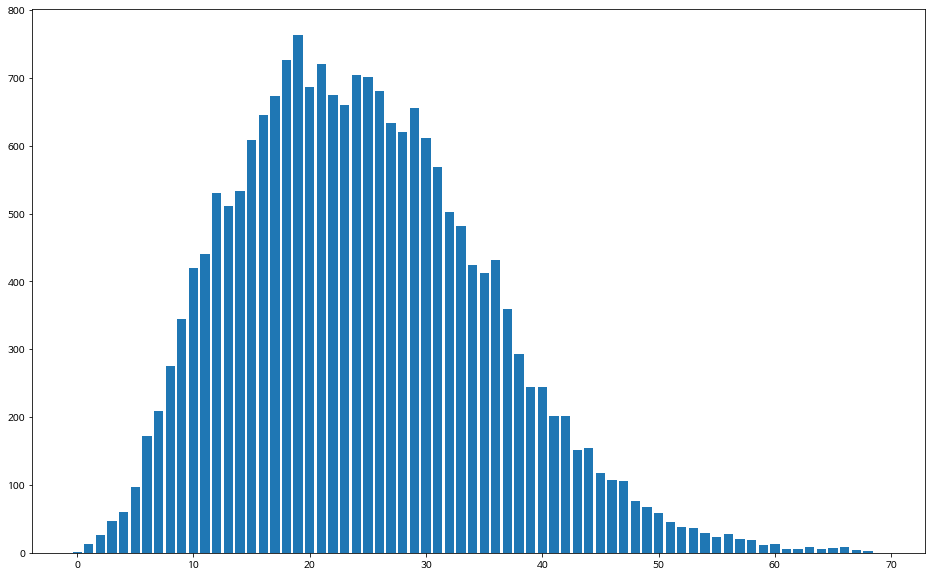

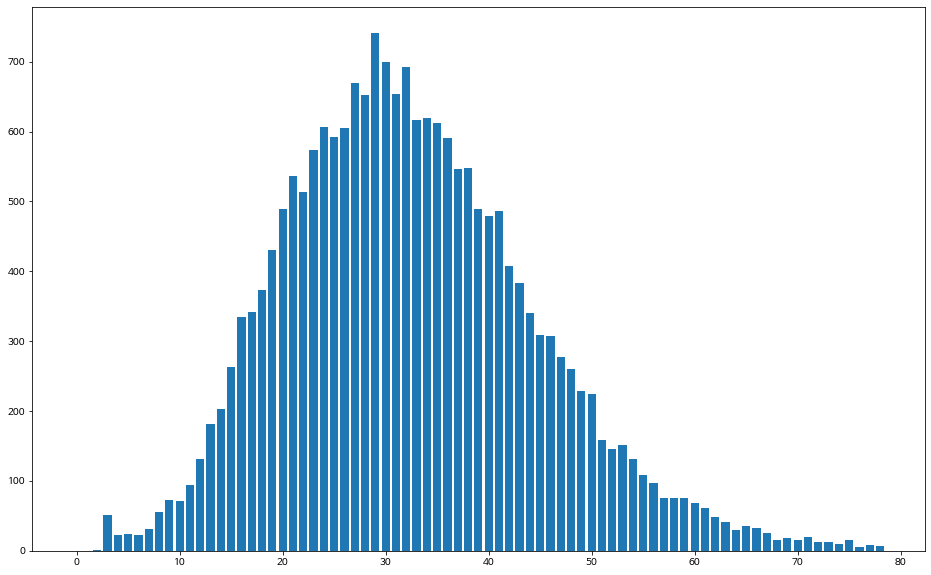

In [45]:
make_graph(num_of_word(enc_corpus))
make_graph(num_of_word(dec_corpus))

### 앞서 사용하였을때 중복데이터가 많아서 특정 길이에서 매우 길었던 기억이 납니다.
### 번역 특성상 다양성을 위해서 그럴 가능성...을 염두에 두고, 서로 짝이 맞는 데이터가 둘다 있었을 경우에만 삭제해주도록 하겠습니다. -> 코드를 잘못짜서 보류합니다!!

In [46]:
# 토큰화하기- 형태소 버전
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Korean Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 28265
Korean Vocab Size: 26955


### 단어개수가 현저히 줄었을 뿐 아니라, 한글의 단어가 영어단어보다 적은 모습을 볼 수 있습니다.
### 정말 놀랍네요.

In [47]:
BUFFER_SIZE = 2
BATCH_SIZE = 2

dataset = tf.data.Dataset.from_tensor_slices((enc_train,dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((2, 70), (2, 80)), types: (tf.int32, tf.int32)>


<BatchDataset shapes: ((2, 70), (2, 80)), types: (tf.int32, tf.int32)>

In [48]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [49]:


class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out


In [50]:

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [51]:
# 코드를 실행하세요.

# BATCH_SIZE     = 16
SRC_VOCAB_SIZE = 20001  #len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = 20001  #len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (2, 30, 512)
Decoder Output: (2, 20001)
Decoder Hidden State: (2, 512)
Attention: (2, 30, 1)


In [52]:
train_data = dataset.__iter__()
val_data = val_dataset.__iter__()

In [53]:
test = next(train_data)
test_x = test[0][:]
test_y = test[1][:]

In [54]:
print(test_x)

tf.Tensor(
[[    1   288    13 19002  4929     2     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    4   170  2069     5    10  1550  1858     3  2501   169 11386     1
   1919    65   177    57    46   170     6   242  1919  1753    71   930
      7     1   483     2     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]], shape=(2, 70), dtype=int32)


In [55]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [56]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [57]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm
import random

EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))[:6000]
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    train_data = dataset.__iter__()
    val_data = val_dataset.__iter__()

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(*next(train_data),
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))[:1200]
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(*next(val_data),
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Epoch  2:  93%|█████████▎| 5584/6000 [1:08:23<05:03,  1.37it/s, Loss 1.8831]

## 이걸로 몇번째 멈추는건지...ㅎㅎ

In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)
translate("I have a Dream. that's you.", encoder, decoder)


Error: Kernel is dead